In [29]:
from typing import Tuple, NamedTuple

import chex
from jumanji import specs, Environment
from jumanji.env import State
from jumanji.types import TimeStep, restart, termination, transition
from jumanji.viewer import Viewer
import jumanji
from jax.tree_util import tree_map
from chex import dataclass
import jax.numpy as jnp
import jax
import matplotlib
from numpy.typing import NDArray
from utils import idx_to_action_enum

In [30]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [31]:
from bin.game_interfaces_binding import Game, GameState, GameAction, GameOptions, ActionType, SubActionType, TileMask, Craftsman, MapState

In [32]:
@dataclass
class ProconState:
    is_pond: chex.Array
    is_castle: chex.Array
    has_t1_wall: chex.Array
    has_t2_wall: chex.Array
    has_t1_craftsman: chex.Array
    has_t2_craftsman: chex.Array
    is_t1_close_territory: chex.Array
    is_t2_close_territory: chex.Array
    is_t1_open_territory: chex.Array
    is_t2_open_territory: chex.Array

    agents: chex.Array # num_of_agents*EnvAgent

    current_turn: chex.Array # ()
    remaining_turns: chex.Array # ()
    
    is_t1_turn: chex.Array # ()
    wall_coeff: chex.Array # ()
    castle_coeff: chex.Array # ()
    territory_coeff: chex.Array # ()

    key: chex.PRNGKey # (2,)

class ProconObservation(NamedTuple):
    is_pond: chex.Array
    is_castle: chex.Array
    has_t1_wall: chex.Array
    has_t2_wall: chex.Array
    has_t1_craftsman: chex.Array
    has_t2_craftsman: chex.Array
    is_t1_close_territory: chex.Array
    is_t2_close_territory: chex.Array
    is_t1_open_territory: chex.Array
    is_t2_open_territory: chex.Array

    agents: chex.Array # num_of_agents*EnvAgent

    current_turn: chex.Array # ()
    remaining_turns: chex.Array # ()
    
    is_t1_turn: chex.Array # ()
    wall_coeff: chex.Array # ()
    castle_coeff: chex.Array # ()
    territory_coeff: chex.Array # ()

class EnvAgent(NamedTuple):
    x: chex.Array
    y: chex.Array
    id: chex.Array
    is_t1: chex.Array

class EnvAction(NamedTuple):
    action: chex.Array # ()
    craftsman_id: chex.Array # ()

In [32]:
from datetime import datetime
from typing import Optional, Sequence

import matplotlib
import matplotlib.animation
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from numpy.typing import NDArray
from jumanji.environments.commons.maze_utils.maze_rendering import MazeViewer
from PIL import Image


from enum import Enum
 
class ScoreType(Enum):
    T1_OPEN_TERRITORY = 0
    T2_OPEN_TERRITORY = 1
    T1_CLOSE_TERRITORY = 2
    T2_CLOSE_TERRITORY = 3
    T1_WALL = 4
    T2_WALL = 5
    T1_CASTLE = 6
    T2_CASTLE = 7
    T1 = 8
    T2 = 9

def calculate_score(state: ProconState):
    width = state.is_pond.shape[1]
    height = state.is_pond.shape[0]

    res = {
        ScoreType.T1_OPEN_TERRITORY: 0,
        ScoreType.T2_OPEN_TERRITORY: 0,
        ScoreType.T1_CLOSE_TERRITORY: 0,
        ScoreType.T2_CLOSE_TERRITORY: 0,
        ScoreType.T1_WALL: 0,
        ScoreType.T2_WALL: 0,
        ScoreType.T1_CASTLE: 0,
        ScoreType.T2_CASTLE: 0,
        ScoreType.T1: 0,
        ScoreType.T2: 0,
    }

    for row in range(height):
        for col in range(width):
            if state.is_t1_close_territory[row, col] or state.is_t1_open_territory[row, col]:
                if state.is_t1_close_territory[row, col]:
                    res[ScoreType.T1_CLOSE_TERRITORY] += state.territory_coeff
                else:
                    res[ScoreType.T1_OPEN_TERRITORY] += state.territory_coeff
                if state.is_castle[row, col]:
                    res[ScoreType.T1_CASTLE] += state.castle_coeff
            elif state.is_t2_close_territory[row, col] or state.is_t2_open_territory[row, col]:
                if state.is_t2_close_territory[row, col]:
                    res[ScoreType.T2_CLOSE_TERRITORY] += state.territory_coeff
                else:
                    res[ScoreType.T2_OPEN_TERRITORY] += state.territory_coeff
                if state.is_castle[row, col]:
                    res[ScoreType.T2_CASTLE] += state.castle_coeff
            elif state.has_t1_wall[row, col]:
                res[ScoreType.T1_WALL] += state.wall_coeff
            elif state.has_t2_wall[row, col]:
                res[ScoreType.T2_WALL] += state.wall_coeff
    
    res[ScoreType.T1] = res[ScoreType.T1_OPEN_TERRITORY] + res[ScoreType.T1_CLOSE_TERRITORY] + res[ScoreType.T1_WALL] + res[ScoreType.T1_CASTLE]
    res[ScoreType.T2] = res[ScoreType.T2_OPEN_TERRITORY] + res[ScoreType.T2_CLOSE_TERRITORY] + res[ScoreType.T2_WALL] + res[ScoreType.T2_CASTLE]

    return res

%matplotlib inline
class ProconViewer(MazeViewer):
    COLORS = {
        "T1_WALL": [0, 0.024, 0.671],
        "T1_CLOSE_TERRITORY": [0.133, 0.161, 1],
        "T1_OPEN_TERRITORY": [0.573, 0.62, 1],
        "T1_CRAFTSMAN": [0.278, 0.922, 0.906],
        "T2_WALL": [0.569, 0, 0],
        "T2_CLOSE_TERRITORY": [1, 0, 0],
        "T2_OPEN_TERRITORY": [1, 0.635, 0.635],
        "T2_CRAFTSMAN": [0.922, 0.278, 0.58],
        "CASTLE": [0.988, 0.91, 0.145],
        "POND": [0,0,0],
    }

    def __init__(self, name: str, render_mode: str = "human") -> None:
        """
        Viewer for the `Procon` environment.

        Args:
            name: the window name to be used when initialising the window.
            render_mode: the mode used to render the environment. Must be one of:
                - "human": render the environment on screen.
                - "rgb_array": return a numpy array frame representing the environment.
        """
        super().__init__(name, render_mode)

        image_names = [
            "c1",
            "c2",
        ]

        self._images = {name: Image.open(f"assets/{name}.png").resize((8,8)) for name in image_names}
        
    def render_with_score(self, state: ProconState) -> Optional[NDArray]:
        self._clear_display()
        fig, ax = self._get_fig_ax()
        ax.clear()
        self._add_grid_image(state, ax)

        score = calculate_score(state)
        fig.suptitle(f"Procon - Territory: {state.territory_coeff}, Wall: {state.wall_coeff}, Castle: {state.castle_coeff}, Turns: {state.current_turn} - {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}")
        ax.set_title(f"Turn {state.current_turn} - Team 1: {score[ScoreType.T1]}, Team 2: {score[ScoreType.T2]}\nT1 - Close: {score[ScoreType.T1_CLOSE_TERRITORY]}, Open: {score[ScoreType.T1_OPEN_TERRITORY]}, Wall: {score[ScoreType.T1_WALL]}, Castle: {score[ScoreType.T1_CASTLE]}\nT2 - Close: {score[ScoreType.T2_CLOSE_TERRITORY]}, Open: {score[ScoreType.T2_OPEN_TERRITORY]}, Wall: {score[ScoreType.T2_WALL]}, Castle: {score[ScoreType.T2_CASTLE]}")
        return self._display(fig)

    def animate_with_score(
        self,
        states: Sequence[ProconState],
        interval: int = 200,
        save_path: Optional[str] = None,
    ) -> matplotlib.animation.FuncAnimation:
        fig, ax = plt.subplots(num=f"{self._name}Animation", figsize=self.FIGURE_SIZE)
        plt.close(fig)


        fig.suptitle(f"Procon - Territory: {states[0].territory_coeff}, Wall: {states[0].wall_coeff}, Castle: {states[0].castle_coeff}, Turns: {states[0].current_turn} - {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}")

        def make_frame(state_index: int) -> None:
            ax.clear()
            state = states[state_index]
            self._add_grid_image(state, ax)
            score = calculate_score(state)
            ax.set_title(f"Turn {state.current_turn} - Team 1: {score[ScoreType.T1]}, Team 2: {score[ScoreType.T2]}\nT1 - Close: {score[ScoreType.T1_CLOSE_TERRITORY]}, Open: {score[ScoreType.T1_OPEN_TERRITORY]}, Wall: {score[ScoreType.T1_WALL]}, Castle: {score[ScoreType.T1_CASTLE]}\nT2 - Close: {score[ScoreType.T2_CLOSE_TERRITORY]}, Open: {score[ScoreType.T2_OPEN_TERRITORY]}, Wall: {score[ScoreType.T2_WALL]}, Castle: {score[ScoreType.T2_CASTLE]}")

        # Create the animation object.
        self._animation = matplotlib.animation.FuncAnimation(
            fig,
            make_frame,
            frames=len(states),
            interval=interval,
        )

        # Save the animation as a gif.
        if save_path:
            self._animation.save(save_path)

        return self._animation


    def _create_grid_image(self, state: ProconState) -> NDArray:
        img = np.ones((*state.has_t1_wall.shape, 3))

        img[state.is_t1_open_territory] = self.COLORS["T1_OPEN_TERRITORY"]
        img[state.is_t2_open_territory] = self.COLORS["T2_OPEN_TERRITORY"]
        img[state.is_t1_close_territory] = self.COLORS["T1_CLOSE_TERRITORY"]
        img[state.is_t2_close_territory] = self.COLORS["T2_CLOSE_TERRITORY"]

        img[state.has_t1_wall] = self.COLORS["T1_WALL"]
        img[state.has_t2_wall] = self.COLORS["T2_WALL"]

        img[state.is_castle] = self.COLORS["CASTLE"]
        img[state.is_pond] = self.COLORS["POND"]

        # add a transparent layer
        img = np.dstack([img, np.ones(img.shape[:2])])

        # upscale array by 8 times
        img = np.kron(img, np.ones((8, 8, 1)))

        img = Image.fromarray((img * 255).astype('uint8'))

        # paste the craftsman on top
        for agent in state.agents:
            if agent.is_t1:
                img.paste(self._images["c1"], (agent.x*8, agent.y*8), self._images["c1"])
            else:
                img.paste(self._images["c2"], (agent.x*8, agent.y*8), self._images["c2"])
        
        img = np.array(img)

        img = self._draw_black_frame_around(img)

        return img


    def _draw_black_frame_around(self, img: NDArray) -> NDArray:
        img = np.pad(img, ((8, 8), (8, 8), (0, 0)),mode='constant', constant_values=255)
        img[:8, :, :3] = img[-8:, :, :3] = img[:, :8, :3] = img[:, -8:, :3] = 0
        return img

In [33]:
max_possible_actions = 17

class ProconJumanji(Environment[ProconState]):
    def __init__(self, gameOptions: GameOptions, map: list[list[int]], craftsmen: list[Craftsman]):
        self.max_turns = gameOptions.maxTurns
        self.map_width = gameOptions.mapWidth
        self.map_height = gameOptions.mapHeight

        self.num_agents = len(craftsmen)

        self.game = Game(gameOptions, map, craftsmen)
        self.game_options = gameOptions

        self._viewer = ProconViewer("Procon", render_mode="human")

        self.initial_state = self._game_state_to_env_state(self.game.getCurrentState(), self.game.gameOptions)

    def __repr__(self) -> str:
        return (
            f"Procon(\n"
            f"\tmap_width={self.map_width},\n"
            f"\tmap_height={self.map_height},\n"
            f"\tnum_agents={self.num_agents!r}, \n"
            ")"
        )

    def reset(self, key: chex.PRNGKey) -> Tuple[ProconState, TimeStep]:
        state = self.initial_state
        timestep = restart(observation=self._env_state_to_observation(state), extras=None)

        return state, timestep
        

    def step(self, state: ProconState, actions: chex.Array) -> Tuple[ProconState, TimeStep[ProconObservation]]:
        game_state = self._env_state_to_game_state(state)
        game_actions = self._env_actions_to_game_actions(actions)
        
        next_game_state = game_state.applyActions(game_actions)

        print(actions)

        for game_action in game_actions:
            print(game_action.craftsmanId, game_action.actionType, game_action.subActionType)

        print(next_game_state.map.calcPoints(self.game.gameOptions, True), next_game_state.map.calcPoints(self.game.gameOptions, False))

        next_env_state = self._game_state_to_env_state(next_game_state, self.game.gameOptions)

        next_observation = self._env_state_to_observation(next_env_state)

        t1_score_prev, t2_score_prev = game_state.map.calcPoints(self.game.gameOptions, True), game_state.map.calcPoints(self.game.gameOptions, False)
        t1_score_next, t2_score_next = next_game_state.map.calcPoints(self.game.gameOptions, True), next_game_state.map.calcPoints(self.game.gameOptions, False)

        reward = np.array([t1_score_next - t1_score_prev, t2_score_next - t2_score_prev])
        done = game_state

        # timestep = jax.lax.cond(
        #     done,
        #     lambda reward, observation, extras: termination(
        #         reward=reward,
        #         observation=observation,
        #         extras=extras,
        #     ),
        #     lambda reward, observation, extras: transition(
        #         reward=reward,
        #         observation=observation,
        #         extras=extras,
        #     ),
        #     reward,
        #     next_observation,
        #     None,
        # )

        timestep = termination(
                reward=reward,
                observation=next_observation,
                extras=None,
        ) if done else transition(
            reward=reward,
            observation=next_observation,
            extras=None,
        )

        return next_env_state, timestep



    def observation_spec(self) -> specs.Spec[ProconObservation]:
        """agent encoding: (x, y, id, is_t1)"""
        def boolArrayOfMapSize(name: str):
            return specs.BoundedArray(
                shape=(self.map_height, self.map_width), 
                dtype=bool, 
                minimum=False, 
                maximum=True, 
                name=name
            )

        return specs.Spec(
            ProconObservation,
            "ObservationSpec",
            is_pond=boolArrayOfMapSize("is_pond"),
            is_castle=boolArrayOfMapSize("is_castle"),
            has_t1_wall=boolArrayOfMapSize("has_t1_wall"),
            has_t2_wall=boolArrayOfMapSize("has_t2_wall"),
            has_t1_craftsman=boolArrayOfMapSize("has_t1_craftsman"),
            has_t2_craftsman=boolArrayOfMapSize("has_t2_craftsman"),
            is_t1_close_territory=boolArrayOfMapSize("is_t1_close_territory"),
            is_t2_close_territory=boolArrayOfMapSize("is_t2_close_territory"),
            is_t1_open_territory=boolArrayOfMapSize("is_t1_open_territory"),
            is_t2_open_territory=boolArrayOfMapSize("is_t2_open_territory"),
            
            agents=specs.MultiDiscreteArray(num_values=jnp.array([[self.map_width, self.map_height, self.num_agents, 2]]*self.num_agents), dtype=jnp.int32, name="agents"),
            current_turn=specs.BoundedArray((), dtype=jnp.int32, minimum=0, maximum=self.max_turns, name="current_turn"),
            remaining_turns=specs.BoundedArray((), dtype=jnp.int32, minimum=0, maximum=self.max_turns, name="remaining_turns"),
            is_t1_turn=specs.BoundedArray((), dtype=bool, minimum=False, maximum=True, name="is_t1_turn"),
        )

    def action_spec(self) -> specs.Spec:
        # (action + craftsman_id) in an array so that their is an order
        return specs.MultiDiscreteArray(num_values=jnp.array([[max_possible_actions, self.num_agents]]*self.num_agents, dtype=jnp.int32), name="action")
    
    def _game_state_to_env_state(self, game_state: GameState, game_options: GameOptions) -> ProconState:
        map_state = game_state.map
        map = np.array(map_state.tiles)

        agents = [EnvAgent(craftsman.x, craftsman.y, craftsman.id, craftsman.isT1) for craftsman in game_state.craftsmen.values()]

        state = ProconState(
            is_pond=map & (1 << TileMask.POND.value) > 0,
            is_castle=map & (1 << TileMask.CASTLE.value) > 0,
            has_t1_wall=map & (1 << TileMask.T1_WALL.value) > 0,
            has_t2_wall=map & (1 << TileMask.T2_WALL.value) > 0,
            has_t1_craftsman=map & (1 << TileMask.T1_CRAFTSMAN.value) > 0,
            has_t2_craftsman=map & (1 << TileMask.T2_CRAFTSMAN.value) > 0,
            is_t1_close_territory=map & (1 << TileMask.T1_CLOSE_TERRITORY.value) > 0,
            is_t2_close_territory=map & (1 << TileMask.T2_CLOSE_TERRITORY.value) > 0,
            is_t1_open_territory=map & (1 << TileMask.T1_OPEN_TERRITORY.value) > 0,
            is_t2_open_territory=map & (1 << TileMask.T2_OPEN_TERRITORY.value) > 0,

            agents=agents,

            current_turn=game_state.turn,
            remaining_turns=self.max_turns - game_state.turn,

            is_t1_turn=game_state.isT1Turn,
            wall_coeff=game_options.wallCoeff,
            castle_coeff=game_options.castleCoeff,
            territory_coeff=game_options.territoryCoeff,
            key=jax.random.PRNGKey(0), # TODO: fix this
        )
        return state

    def _env_state_to_game_state(self, env_state: ProconState) -> GameState:
        go = self.game.gameOptions
        map_state = MapState(go.mapWidth, go.mapHeight)
        map = np.zeros_like(np.array(map_state.tiles), dtype=jnp.int32)

        map |= env_state.is_pond << TileMask.POND.value
        map |= env_state.is_castle << TileMask.CASTLE.value
        map |= env_state.has_t1_wall << TileMask.T1_WALL.value
        map |= env_state.has_t2_wall << TileMask.T2_WALL.value
        map |= env_state.has_t1_craftsman << TileMask.T1_CRAFTSMAN.value
        map |= env_state.has_t2_craftsman << TileMask.T2_CRAFTSMAN.value
        map |= env_state.is_t1_close_territory << TileMask.T1_CLOSE_TERRITORY.value
        map |= env_state.is_t2_close_territory << TileMask.T2_CLOSE_TERRITORY.value
        map |= env_state.is_t1_open_territory << TileMask.T1_OPEN_TERRITORY.value
        map |= env_state.is_t2_open_territory << TileMask.T2_OPEN_TERRITORY.value


        map_state.tiles = map.tolist()

        craftsmen = {int(craftsman.id): Craftsman(craftsman.id, craftsman.x, craftsman.y, craftsman.is_t1) for craftsman in env_state.agents}

        game_state = GameState(map_state, craftsmen, env_state.current_turn, env_state.is_t1_turn)
        return game_state


    def _env_state_to_observation(self, env_state: ProconState) -> ProconObservation:
        return ProconObservation(
            is_pond=env_state.is_pond,
            is_castle=env_state.is_castle,
            has_t1_wall=env_state.has_t1_wall,
            has_t2_wall=env_state.has_t2_wall,
            has_t1_craftsman=env_state.has_t1_craftsman,
            has_t2_craftsman=env_state.has_t2_craftsman,
            is_t1_close_territory=env_state.is_t1_close_territory,
            is_t2_close_territory=env_state.is_t2_close_territory,
            is_t1_open_territory=env_state.is_t1_open_territory,
            is_t2_open_territory=env_state.is_t2_open_territory,

            agents=env_state.agents,

            current_turn=env_state.current_turn,
            remaining_turns=env_state.remaining_turns,

            is_t1_turn=env_state.is_t1_turn,
            wall_coeff=env_state.wall_coeff,
            castle_coeff=env_state.castle_coeff,
            territory_coeff=env_state.territory_coeff,
        )

    def _env_action_to_game_action(self, env_action: EnvAction) -> GameAction:
        return GameAction(env_action.craftsman_id, *idx_to_action_enum(env_action.action))

    def _env_actions_to_game_actions(self, env_actions: chex.Array) -> chex.Array:
        return [self._env_action_to_game_action(env_action) for env_action in env_actions]


    def render(self, state: ProconState) -> Optional[NDArray]:
        return self._viewer.render_with_score(state)

    def animate(
        self,
        states: Sequence[ProconState],
        interval: int = 200,
        save_path: Optional[str] = None,
    ) -> matplotlib.animation.FuncAnimation:
        return self._viewer.animate_with_score(states, interval, save_path)

# ENV_ID = "Procon-v0"
# if not ENV_ID in _REGISTRY:
#     register(id="Procon-v0", entry_point="procon:ProconJumanji")

In [34]:

action_path = "test-cases/match-259.txt"
map_path = "test-cases/map-259-game-2.txt"

from utils import load_offline_game, load_offline_actions

game_options, map, craftsmen, craftsman_strid_to_intid = load_offline_game(map_path)

actions = load_offline_actions(action_path, craftsman_strid_to_intid)

[EnvAction(action=5, craftsman_id=0), EnvAction(action=4, craftsman_id=2), EnvAction(action=2, craftsman_id=3), EnvAction(action=4, craftsman_id=1)]
0 ActionType.MOVE SubActionType.MOVE_UP_RIGHT
2 ActionType.MOVE SubActionType.MOVE_UP_LEFT
3 ActionType.MOVE SubActionType.MOVE_LEFT
1 ActionType.MOVE SubActionType.MOVE_UP_LEFT
0 0
[EnvAction(action=3, craftsman_id=4), EnvAction(action=1, craftsman_id=5), EnvAction(action=10, craftsman_id=6), EnvAction(action=10, craftsman_id=7)]
4 ActionType.MOVE SubActionType.MOVE_RIGHT
5 ActionType.MOVE SubActionType.MOVE_DOWN
6 ActionType.BUILD SubActionType.BUILD_LEFT
7 ActionType.BUILD SubActionType.BUILD_LEFT
0 2
[EnvAction(action=9, craftsman_id=0), EnvAction(action=4, craftsman_id=1), EnvAction(action=4, craftsman_id=2), EnvAction(action=9, craftsman_id=3)]
0 ActionType.BUILD SubActionType.BUILD_DOWN
1 ActionType.MOVE SubActionType.MOVE_UP_LEFT
2 ActionType.MOVE SubActionType.MOVE_UP_LEFT
3 ActionType.BUILD SubActionType.BUILD_DOWN
2 2
[EnvAction

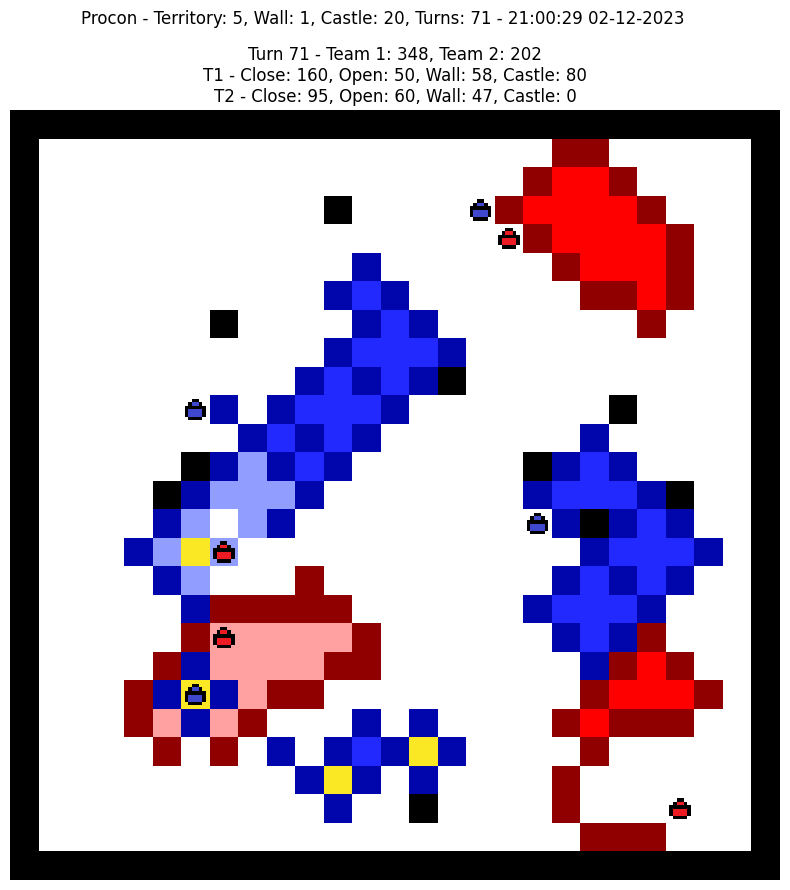

In [35]:
env = ProconJumanji(game_options, map, craftsmen)

random_key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(random_key)
batch_size = 1

keys = jax.random.split(key1, batch_size)
state, timestep = env.reset(keys[0])

def game_actions_to_env_actions(all_turns_actions) -> list[list[EnvAction]]:
    env_all_turns_actions: list[list[EnvAction]] = []
    for actions in all_turns_actions:
        turn_actions: list[EnvAction] = []
        for action in actions:
            turn_actions.append(EnvAction(action.subActionType.value, action.craftsmanId))
        env_all_turns_actions.append(turn_actions)
            
    return env_all_turns_actions

env_actions = game_actions_to_env_actions(actions)

state_list = [state]

for i, actions_in_turn in enumerate(env_actions):
    # print(actions_in_turn)
    state, timestep = env.step(state, actions_in_turn)
    state_list.append(state)
env.animate(state_list, interval=200, save_path=f'records/test.gif')
env.render(state_list[-1])
    


In [36]:
env.observation_spec()

ObservationSpec(
	is_pond=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='is_pond', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	is_castle=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='is_castle', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	has_t1_wall=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='has_t1_wall', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	has_t2_wall=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='has_t2_wall', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	has_t1_craftsman=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='has_t1_craftsman', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	has_t2_craftsman=BoundedArray(shape=(25, 25), dtype=dtype('bool'), name='has_t2_craftsman', minimum=Array(False, dtype=bool), maximum=Array(True, dtype=bool)),
	is_t1_close_territory=BoundedArray(shape=(25, 25), dtype=dtype('bool

In [37]:
from typing import Any, Callable, Dict, Sequence, Tuple
from colorama import Fore, Style

import optax
from optax._src.base import OptState
import chex
import distrax
import flax.linen as nn
from flax import struct
from flax.core.frozen_dict import FrozenDict
from flax.linen.initializers import constant, orthogonal
import jax
import jax.numpy as jnp
import numpy as np

# Env requirements
import jumanji
from jumanji.env import Environment
from jumanji import specs
from jumanji.wrappers import AutoResetWrapper

# Mava Helpful functions and types
from mava.utils.jax import merge_leading_dims
from mava.wrappers.jumanji import (
    AgentIDWrapper,
    LogWrapper,
    ObservationGlobalState,
    RwareMultiAgentWithGlobalStateWrapper,
)
from mava.types import ExperimentOutput, LearnerState, OptStates, Params, PPOTransition
from mava.evaluator import evaluator_setup

# Plot requirements
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
%matplotlib inline
import seaborn as sns
import time
     

## The network

In [38]:
class Actor(nn.Module):
    """Actor Network."""

    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, observation: ProconObservation) -> distrax.Categorical:
        """Forward pass."""
        x = observation.agents_view

        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            actor_output
        )
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_output)

        masked_logits = jnp.where(
            observation.action_mask,
            actor_output,
            jnp.finfo(jnp.float32).min,
        )
        actor_policy = distrax.Categorical(logits=masked_logits)

        return actor_policy


class Critic(nn.Module):
    """Critic Network."""

    @nn.compact
    def __call__(self, observation: ProconObservation) -> chex.Array:
        """Forward pass."""

        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            observation.global_state
        )
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            critic_output
        )
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic_output
        )

        return jnp.squeeze(critic_output, axis=-1)


## Learner function

In [39]:
def get_learner_fn(
    env: jumanji.Environment,
    apply_fns: Tuple[Callable, Callable],
    update_fns: Tuple[Callable, Callable],
    config: Dict,
) -> Callable:
    """Get the learner function."""

    # Unpack apply and update functions.
    actor_apply_fn, critic_apply_fn = apply_fns
    actor_update_fn, critic_update_fn = update_fns

    def _update_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, Tuple]:
        """A single update of the network.

        This function steps the environment and records the trajectory batch for
        training. It then calculates advantages and targets based on the recorded
        trajectory and updates the actor and critic networks based on the calculated
        losses.

        Args:
            learner_state (NamedTuple):
                - params (Params): The current model parameters.
                - opt_states (OptStates): The current optimizer states.
                - rng (PRNGKey): The random number generator state.
                - env_state (State): The environment state.
                - last_timestep (TimeStep): The last timestep in the current trajectory.
            _ (Any): The current metrics info.
        """

        def _env_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, PPOTransition]:
            """Step the environment."""
            params, opt_states, rng, env_state, last_timestep = learner_state

            # SELECT ACTION
            rng, policy_rng = jax.random.split(rng)
            actor_policy = actor_apply_fn(params.actor_params, last_timestep.observation)
            value = critic_apply_fn(params.critic_params, last_timestep.observation)
            action = actor_policy.sample(seed=policy_rng)
            log_prob = actor_policy.log_prob(action)

            # STEP ENVIRONMENT
            env_state, timestep = jax.vmap(env.step, in_axes=(0, 0))(env_state, action)

            # LOG EPISODE METRICS
            done, reward = jax.tree_util.tree_map(
                lambda x: jnp.repeat(x, config["num_agents"]).reshape(config["num_envs"], -1),
                (timestep.last(), timestep.reward),
            )
            info = {
                "episode_return": env_state.episode_return_info,
                "episode_length": env_state.episode_length_info,
            }

            transition = PPOTransition(
                done, action, value, reward, log_prob, last_timestep.observation, info
            )
            learner_state = LearnerState(params, opt_states, rng, env_state, timestep)
            return learner_state, transition

        # STEP ENVIRONMENT FOR ROLLOUT LENGTH
        learner_state, traj_batch = jax.lax.scan(
            _env_step, learner_state, None, config["rollout_length"]
        )

        # CALCULATE ADVANTAGE
        params, opt_states, rng, env_state, last_timestep = learner_state
        last_val = critic_apply_fn(params.critic_params, last_timestep.observation)

        def _calculate_gae(
            traj_batch: PPOTransition, last_val: chex.Array
        ) -> Tuple[chex.Array, chex.Array]:
            """Calculate the GAE."""

            def _get_advantages(gae_and_next_value: Tuple, transition: PPOTransition) -> Tuple:
                """Calculate the GAE for a single transition."""
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                delta = reward + config["gamma"] * next_value * (1 - done) - value
                gae = delta + config["gamma"] * config["gae_lambda"] * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        def _update_epoch(update_state: Tuple, _: Any) -> Tuple:
            """Update the network for a single epoch."""

            def _update_minibatch(train_state: Tuple, batch_info: Tuple) -> Tuple:
                """Update the network for a single minibatch."""

                # UNPACK TRAIN STATE AND BATCH INFO
                params, opt_states = train_state
                traj_batch, advantages, targets = batch_info

                def _actor_loss_fn(
                    actor_params: FrozenDict,
                    actor_opt_state: OptState,
                    traj_batch: PPOTransition,
                    gae: chex.Array,
                ) -> Tuple:
                    """Calculate the actor loss."""
                    # RERUN NETWORK
                    actor_policy = actor_apply_fn(actor_params, traj_batch.obs)
                    log_prob = actor_policy.log_prob(traj_batch.action)

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["clip_eps"],
                            1.0 + config["clip_eps"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = actor_policy.entropy().mean()

                    total_loss_actor = loss_actor - config["ent_coef"] * entropy
                    return total_loss_actor, (loss_actor, entropy)

                def _critic_loss_fn(
                    critic_params: FrozenDict,
                    critic_opt_state: OptState,
                    traj_batch: PPOTransition,
                    targets: chex.Array,
                ) -> Tuple:
                    """Calculate the critic loss."""
                    # RERUN NETWORK
                    value = critic_apply_fn(critic_params, traj_batch.obs)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config["clip_eps"], config["clip_eps"]
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    critic_total_loss = config["vf_coef"] * value_loss
                    return critic_total_loss, (value_loss)

                # CALCULATE ACTOR LOSS
                actor_grad_fn = jax.value_and_grad(_actor_loss_fn, has_aux=True)
                actor_loss_info, actor_grads = actor_grad_fn(
                    params.actor_params, opt_states.actor_opt_state, traj_batch, advantages
                )

                # CALCULATE CRITIC LOSS
                critic_grad_fn = jax.value_and_grad(_critic_loss_fn, has_aux=True)
                critic_loss_info, critic_grads = critic_grad_fn(
                    params.critic_params, opt_states.critic_opt_state, traj_batch, targets
                )

                # Compute the parallel mean (pmean) over the batch.
                # This calculation is inspired by the Anakin architecture demo notebook.
                # available at https://tinyurl.com/26tdzs5x
                # This pmean could be a regular mean as the batch axis is on the same device.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="batch"
                )
                # pmean over devices.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="device"
                )

                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="batch"
                )
                # pmean over devices.
                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="device"
                )

                # UPDATE ACTOR PARAMS AND OPTIMISER STATE
                actor_updates, actor_new_opt_state = actor_update_fn(
                    actor_grads, opt_states.actor_opt_state
                )
                actor_new_params = optax.apply_updates(params.actor_params, actor_updates)

                # UPDATE CRITIC PARAMS AND OPTIMISER STATE
                critic_updates, critic_new_opt_state = critic_update_fn(
                    critic_grads, opt_states.critic_opt_state
                )
                critic_new_params = optax.apply_updates(params.critic_params, critic_updates)

                new_params = Params(actor_new_params, critic_new_params)
                new_opt_state = OptStates(actor_new_opt_state, critic_new_opt_state)

                # PACK LOSS INFO
                total_loss = actor_loss_info[0] + critic_loss_info[0]
                value_loss = critic_loss_info[1]
                actor_loss = actor_loss_info[1][0]
                entropy = actor_loss_info[1][1]
                loss_info = (
                    total_loss,
                    (value_loss, actor_loss, entropy),
                )

                return (new_params, new_opt_state), loss_info

            params, opt_states, traj_batch, advantages, targets, rng = update_state
            rng, shuffle_rng = jax.random.split(rng)

            # SHUFFLE MINIBATCHES
            batch_size = config["rollout_length"] * config["num_envs"]
            permutation = jax.random.permutation(shuffle_rng, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = jax.tree_util.tree_map(lambda x: merge_leading_dims(x, 2), batch)
            shuffled_batch = jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )
            minibatches = jax.tree_util.tree_map(
                lambda x: jnp.reshape(x, [config["num_minibatches"], -1] + list(x.shape[1:])),
                shuffled_batch,
            )

            # UPDATE MINIBATCHES
            (params, opt_states), loss_info = jax.lax.scan(
                _update_minibatch, (params, opt_states), minibatches
            )

            update_state = (params, opt_states, traj_batch, advantages, targets, rng)
            return update_state, loss_info

        update_state = (params, opt_states, traj_batch, advantages, targets, rng)

        # UPDATE EPOCHS
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config["ppo_epochs"]
        )

        params, opt_states, traj_batch, advantages, targets, rng = update_state
        learner_state = LearnerState(params, opt_states, rng, env_state, last_timestep)
        metric = traj_batch.info
        return learner_state, (metric, loss_info)

    def learner_fn(learner_state: LearnerState) -> ExperimentOutput:
        """Learner function.

        This function represents the learner, it updates the network parameters
        by iteratively applying the `_update_step` function for a fixed number of
        updates. The `_update_step` function is vectorized over a batch of inputs.

        Args:
            learner_state (NamedTuple):
                - params (Params): The initial model parameters.
                - opt_states (OptStates): The initial optimizer states.
                - rng (chex.PRNGKey): The random number generator state.
                - env_state (LogEnvState): The environment state.
                - timesteps (TimeStep): The initial timestep in the initial trajectory.
        """

        batched_update_step = jax.vmap(_update_step, in_axes=(0, None), axis_name="batch")

        learner_state, (metric, loss_info) = jax.lax.scan(
            batched_update_step, learner_state, None, config["num_updates_per_eval"]
        )
        total_loss, (value_loss, loss_actor, entropy) = loss_info
        return ExperimentOutput(
            learner_state=learner_state,
            episodes_info=metric,
            total_loss=total_loss,
            value_loss=value_loss,
            loss_actor=loss_actor,
            entropy=entropy,
        )

    return learner_fn


## Learner setup

In [40]:
def learner_setup(
    env: ProconJumanji, rngs: chex.Array, config: Dict
) -> Tuple[Callable, Actor, LearnerState]:
    """Initialise learner_fn, network, optimiser, environment and states."""
    # Get available TPU cores.
    n_devices = len(jax.devices())

    # Get number of actions and agents.
    num_actions = 17
    num_agents = env.action_spec().shape[0]
    print(f"num_agents: {num_agents}. Setting num_agents to config.")
    
    config["num_agents"] = num_agents

    # PRNG keys.
    rng, rng_p = rngs

    # Define network and optimiser.
    actor_network = Actor(num_actions)
    critic_network = Critic()
    actor_optim = optax.chain(
        optax.clip_by_global_norm(config["max_grad_norm"]),
        optax.adam(config["actor_lr"], eps=1e-5),
    )
    critic_optim = optax.chain(
        optax.clip_by_global_norm(config["max_grad_norm"]),
        optax.adam(config["critic_lr"], eps=1e-5),
    )

    # Initialise observation.
    obs = env.observation_spec().generate_value()
    # Select only obs for a single agent.
    # init_x = ObservationGlobalState(
    #     agents_view=obs.agents_view[0],
    #     action_mask=obs.action_mask[0],
    #     global_state=obs.global_state[0],
    #     step_count=obs.current_turn,
    # )
    init_x = obs
    init_x = jax.tree_util.tree_map(lambda x: x[None, ...], init_x)

    # Initialise actor params and optimiser state.
    actor_params = actor_network.init(rng_p, init_x)
    actor_opt_state = actor_optim.init(actor_params)

    # Initialise critic params and optimiser state.
    critic_params = critic_network.init(rng_p, init_x)
    critic_opt_state = critic_optim.init(critic_params)

    # Vmap network apply function over number of agents.
    vmapped_actor_network_apply_fn = jax.vmap(
        actor_network.apply,
        in_axes=(None, 1),
        out_axes=(1),
    )
    vmapped_critic_network_apply_fn = jax.vmap(
        critic_network.apply,
        in_axes=(None, 1),
        out_axes=(1),
    )

    # Pack apply and update functions.
    apply_fns = (vmapped_actor_network_apply_fn, vmapped_critic_network_apply_fn)
    update_fns = (actor_optim.update, critic_optim.update)

    # Get batched iterated update and replicate it to pmap it over cores.
    learn = get_learner_fn(env, apply_fns, update_fns, config)
    learn = jax.pmap(learn, axis_name="device")

    # Broadcast params and optimiser state to cores and batch.
    broadcast = lambda x: jnp.broadcast_to(x, (n_devices, config["update_batch_size"]) + x.shape)
    actor_params = jax.tree_map(broadcast, actor_params)
    actor_opt_state = jax.tree_map(broadcast, actor_opt_state)
    critic_params = jax.tree_map(broadcast, critic_params)
    critic_opt_state = jax.tree_map(broadcast, critic_opt_state)

    # Initialise environment states and timesteps.
    rng, *env_rngs = jax.random.split(
        rng, n_devices * config["update_batch_size"] * config["num_envs"] + 1
    )
    env_states, timesteps = jax.vmap(env.reset, in_axes=(0))(
        jnp.stack(env_rngs),
    )

    # Split rngs for each core.
    rng, *step_rngs = jax.random.split(rng, n_devices * config["update_batch_size"] + 1)

    # Add dimension to pmap over.
    reshape_step_rngs = lambda x: x.reshape((n_devices, config["update_batch_size"]) + x.shape[1:])
    step_rngs = reshape_step_rngs(jnp.stack(step_rngs))
    reshape_states = lambda x: x.reshape(
        (n_devices, config["update_batch_size"], config["num_envs"]) + x.shape[1:]
    )
    env_states = jax.tree_util.tree_map(reshape_states, env_states)
    timesteps = jax.tree_util.tree_map(reshape_states, timesteps)

    params = Params(actor_params, critic_params)
    opt_states = OptStates(actor_opt_state, critic_opt_state)

    init_learner_state = LearnerState(params, opt_states, step_rngs, env_states, timesteps)
    return learn, actor_network, init_learner_state


In [41]:
def plot_performance(metrics, ep_returns, start_time):
      plt.figure(figsize=(8, 4))
      clear_output(wait=True)

      ep_returns.append(metrics.episodes_info["episode_return"].mean())
      # Plot the data
      plt.plot(np.linspace(0, (time.time()-start_time)/ 60.0, len(list(ep_returns))),list(ep_returns))
      plt.xlabel('Run Time [Minutes]')
      plt.ylabel('Episode Return')
      plt.title(f'Robotic Warehouse with 4 Agents')
      # Show the plot
      plt.show()
      return ep_returns

In [42]:
config = {
    "actor_lr": 2.5e-4,
    "critic_lr": 2.5e-4,
    "update_batch_size": 2,
    "rollout_length": 128,
    "num_updates": 150,
    "num_envs": 512,
    "ppo_epochs": 16,
    "num_minibatches": 32,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_eps": 0.2,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "env_name": "Procon-v0",
    "num_eval_episodes": 32,
    "num_evaluation": 50,
    "evaluation_greedy": False,
    "add_agent_id": True,
    "seed":42
}

In [43]:
env = ProconJumanji(go, map_formatted, craftsmen_formatted)
env = AutoResetWrapper(env)
env = LogWrapper(env)
eval_env = ProconJumanji(go, map_formatted, craftsmen_formatted)

NameError: name 'go' is not defined

In [ ]:
# this block is for testing


In [ ]:
# PRNG keys.
rng, rng_e, rng_p = jax.random.split(jax.random.PRNGKey(config["seed"]), num=3)

# Setup learner.
learn, actor_network, learner_state = learner_setup(env, (rng, rng_p), config)

# Setup evaluator.
evaluator, absolute_metric_evaluator, (trained_params, eval_rngs) = evaluator_setup(
        eval_env=eval_env,
        rng_e=rng_e,
        network=actor_network,
        params=learner_state.params.actor_params,
        config=config,
)
     

num_agents: 8. Setting num_agents to config.


AttributeError: 'ProconObservation' object has no attribute 'agents_view'

In [ ]:

# Calculate total timesteps.
n_devices = len(jax.devices())
config["num_updates_per_eval"] = config["num_updates"] // config["num_evaluation"]
steps_per_rollout = (
    n_devices
    * config["num_updates_per_eval"]
    * config["rollout_length"]
    * config["update_batch_size"]
    * config["num_envs"]
)

# Run experiment for a total number of evaluations.
ep_returns=[]
     


learn(learner_state)

# Compile the evaluator function
_ = evaluator(trained_params, eval_rngs)

     

: 

In [ ]:
start_time=time.time()
for i in range(config["num_evaluation"]):
    # Train.
    learner_output = learn(learner_state)
    jax.block_until_ready(learner_output)


    # Prepare for evaluation.
    trained_params = jax.tree_util.tree_map(
            lambda x: x[:, 0, ...],
            learner_output.learner_state.params.actor_params,  # Select only actor params
    )
    rng_e, *eval_rngs = jax.random.split(rng_e, n_devices + 1)
    eval_rngs = jnp.stack(eval_rngs)
    eval_rngs = eval_rngs.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_rngs)
    jax.block_until_ready(evaluator_output)
    ep_returns=plot_performance(evaluator_output, ep_returns, start_time)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params= jax.tree_util.tree_map(
    lambda x: x[0, 0, ...], learner_output.learner_state.params.actor_params
)
print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

: 